In [7]:
!pip install -q kaggle


In [8]:
!mkdir -p ~/.kaggle
# after uploading via GUI:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
# Cell 3 (fixed) – make the folder, download, then unzip
!mkdir -p data/raw
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -q
!unzip -q chest-xray-pneumonia.zip -d data/raw


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [10]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, Dropout, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SIZE = 224
DATA_ROOT = "data/raw/chest_xray"


In [11]:
def load_data(split="train"):
    X, y = [], []
    classes = ["NORMAL","PNEUMONIA"]
    for idx, cls in enumerate(classes):
        folder = os.path.join(DATA_ROOT, split, cls)
        for fname in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(img)
            y.append(idx)
    X = np.array(X)[...,None]/255.0
    y = to_categorical(y, num_classes=2)
    return X, y

# load train/val/test
X_train, y_train = load_data("train")
X_val,   y_val   = load_data("val")
X_test,  y_test  = load_data("test")

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (5216, 224, 224, 1) (5216, 2)
Val:   (16, 224, 224, 1) (16, 2)
Test:  (624, 224, 224, 1) (624, 2)


In [12]:
def build_cnn(input_shape=(IMG_SIZE,IMG_SIZE,1), num_classes=2):
    inp = Input(shape=input_shape)
    x = Conv2D(32,3,activation="relu")(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(64,3,activation="relu")(x)
    x = MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inp, out)

model = build_cnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,946 (74.01 KB)

 Trainable params: 18,946 (74.01 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7319 - loss: 0.5895

163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7320 - loss: 0.5895 - val_accuracy: 0.5000 - val_loss: 0.7996
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7415 - loss: 0.5697

163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7415 - loss: 0.5696 - val_accuracy: 0.4375 - val_loss: 0.7500
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7353 - loss: 0.5462 - val_accuracy: 0.4375 - val_loss: 0.8224
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7282 - loss: 0.5370

163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7282 - loss: 0.5369 - val_accuracy: 0.4375 - val_loss: 0.6699
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7560 - loss: 0.4855 - val_accuracy: 0.5000 - val_loss: 0.7823
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7827 - loss: 0.4356 - val_accuracy: 0.5000 - val_loss: 0.7257
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8059 - loss: 0.4068

163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8059 - loss: 0.4068 - val_accuracy: 0.6875 - val_loss: 0.5882
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8175 - loss: 0.3920 - val_accuracy: 0.5625 - val_loss: 0.6445
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8208 - loss: 0.3800 - val_accuracy: 0.5000 - val_loss: 0.9699
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8332 - loss: 0.3607

163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8333 - loss: 0.3607 - val_accuracy: 0.8750 - val_loss: 0.5111
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8457 - loss: 0.3371 - val_accuracy: 0.5625 - val_loss: 0.7349
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8499 - loss: 0.3283 - val_accuracy: 0.5625 - val_loss: 0.7880
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.8447 - loss: 0.3409 - val_accuracy: 0.5625 - val_loss: 0.6807
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8640 - loss: 0.3063 - val_accuracy: 0.5625 - val_loss: 0.9751
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8683 - loss: 0.3010 - val_accuracy: 0.5625 - val_loss: 0.7245


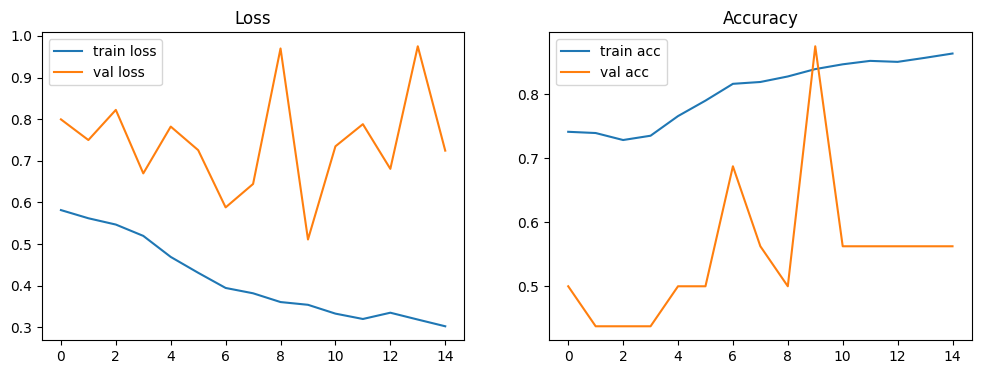

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"],   label="val loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy")
plt.show()


In [15]:
model = load_model("best_model.h5")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.7532


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       234
           1       0.84      0.75      0.79       390

    accuracy                           0.75       624
   macro avg       0.74      0.75      0.74       624
weighted avg       0.76      0.75      0.76       624



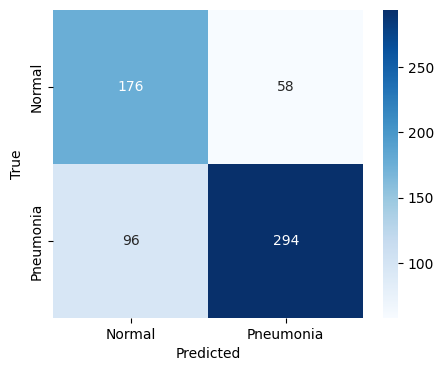

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


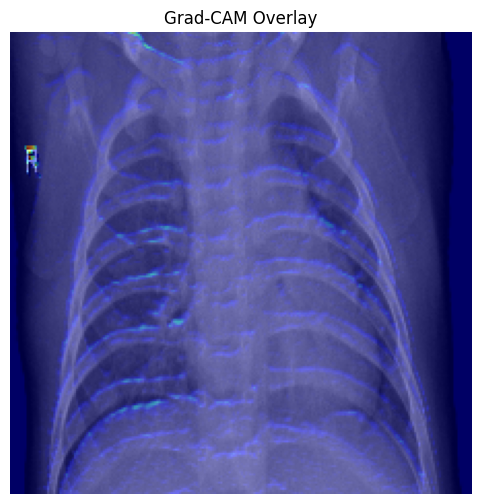

In [19]:
def grad_cam(img, model, layer_name="conv2d"):
    # Build a smaller model that outputs conv features + predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    img_tensor = tf.expand_dims(img, 0)  # add batch dim

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        class_idx = tf.argmax(preds[0])
        loss = preds[0][class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]  # remove batch dim
    pooled_grads = tf.reduce_mean(grads, axis=(0,1))

    conv_outputs = conv_outputs[0]  # remove batch dim
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)              # only positive
    cam = cam / tf.reduce_max(cam)        # normalize to [0,1]
    heatmap = cam.numpy()

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    return heatmap

# Example overlay on the first test image:
img = X_test[0].squeeze()
heat = grad_cam(X_test[0], model, layer_name="conv2d")

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(heat, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()
